In [1]:
import os, sys
import csv
import scipy.io
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.sync_df_utlis import (
    find_calib_file,
    calculate_frame_brightness,
    find_brightness_drop,
)
import numpy as np

def load_mini_timestamps(csv_path):
    timestamps = []
    with open(csv_path, 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip header row
        for row in reader:
            frame_number, timestamp_ms, _ = row
            # timestamps.append(int(timestamp_ms))
            timestamps.append(int(timestamp_ms) / 1000.0)  # Convert to seconds
    return timestamps

def load_sixcam_timestamps(rec_path, camera_number):
    frametimes_path = f'{rec_path}/videos/Camera{camera_number}/frametimes.npy'
    if os.path.exists(frametimes_path):
        return np.load(frametimes_path)
    else:
        raise FileNotFoundError(f"Frametimes file not found at {frametimes_path}")


#for dannce:
# def find_calib_file(base_folder):
#     for file_name in os.listdir(base_folder):
#         if file_name.endswith('label3d_dannce.mat'):
#             return os.path.join(base_folder, file_name)
#     return None

# def load_frametimes_6cam(base_path, num_cameras=6):
#     """
#     Load frametimes.npy files for a specified number of cameras.

#     Parameters:
#     - base_path (str): The base path where the main folder is located.
#     - num_cameras (int): The number of cameras to load frametimes for. Default is 6.

#     Returns:
#     - dict: A dictionary with camera names as keys and frametimes data as values.
#     """
#     frametimes = {}
#     for i in range(1, num_cameras + 1):
#         camera_path = f'{base_path}/videos/Camera{i}/frametimes.npy'
#         try:
#             frametimes[f'Camera{i}'] = np.load(camera_path)
#             print(f"Loaded frametimes for Camera{i}")
#         except FileNotFoundError:
#             print(f"File not found: {camera_path}")
#     return frametimes


In [ ]:
# def find_camera_with_frame_start(base_folder):
#     calib_file = find_calib_file(rec_path)
#     calib_data = scipy.io.loadmat(calib_file)
#     sync_data = calib_data['sync']
#     for cam_idx in range(sync_data.shape[0]):
#         cam_sync = sync_data[cam_idx][0]
#         data_frame = cam_sync['data_frame'][0][0][0]  # Directly access the known key
#         if data_frame[0] == 1:
#             print(f"Camera index with data_frame starting at 1: {cam_idx}")
#             return cam_idx
#     print("No camera with data_frame starting at 1 found.")
#     return None
    
# def find_camera_with_frame_start(sync_data):
#     for cam_idx in range(sync_data.shape[0]):
#         cam_sync = sync_data[cam_idx][0]
#         keys = cam_sync.dtype.names
#         for key in keys:
#             data_frame = cam_sync[key][0][0][0]
#             if data_frame[0] == 1:
#                 print(f"Camera index with data_frame starting at 1: {cam_idx}")
#                 print(f"Key used: {key}")
#                 return cam_idx, key
#     print("No camera with data_frame starting at 1 found.")
#     return None, None

# calib_file = find_calib_file(rec_path)
# calib_data = scipy.io.loadmat(calib_file)
# sync = calib_data['sync']
# camera_index, key_used = find_camera_with_frame_start(sync)

In [ ]:
# rec_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35'
# mini_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00'

# mini_cam_path = os.path.join(mini_path, 'My_First_WebCam')
# mini_cam_timestamps = os.path.join(mini_cam_path, 'timeStamps.csv')
# mini_cam_vid = os.path.join(mini_cam_path, '0.avi')

# miniscope_path = os.path.join(mini_path, 'My_V4_Miniscope')
# miniscope_timestamps = os.path.join(miniscope_path, 'timeStamps.csv')



# # camera_index = find_camera_with_frame_start(rec_path)

Camera index with data_frame starting at 1: 0


Camera index with data_frame starting at 1: 0


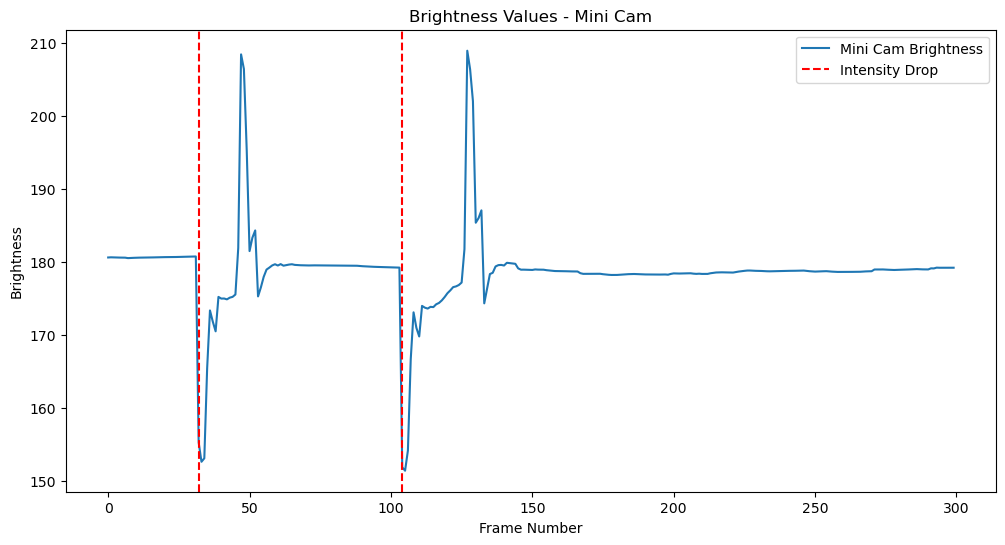

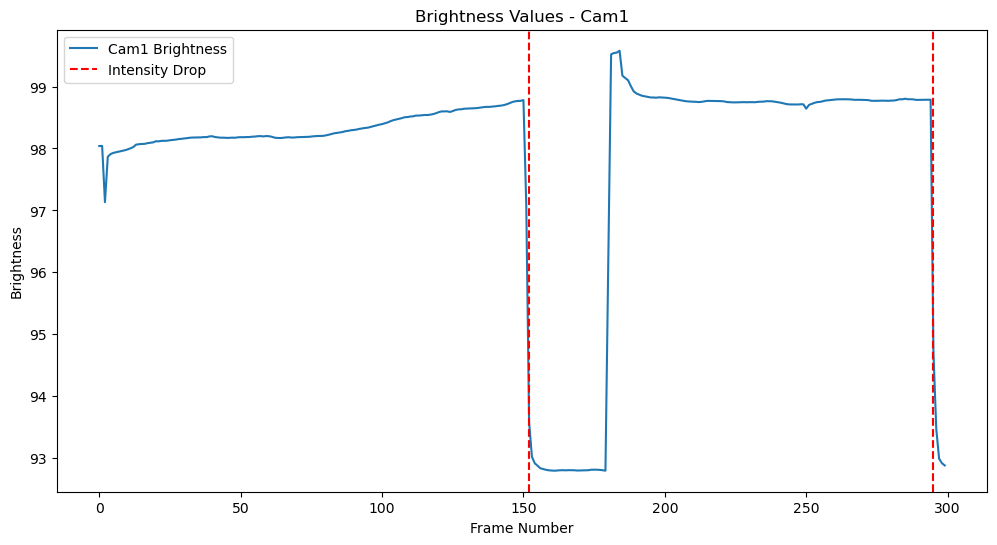

In [2]:
import os
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.mini_dannce_sync import sync_videos


rec_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35'
mini_path = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1mini_sorted/20240910-V1-R/customEntValHere/2024_11_01/11_39_00'
resultsss = sync_videos(
    rec_path,
    mini_path,
    start_frame=0,
    end_frame=300,
    threshold_mini=20,
    threshold_sixcam=3
)

In [3]:
from scipy.interpolate import interp1d

sync_frame_mini = resultsss.get("sync_frame_mini")  # Synchronization frame in Mini Cam
sync_frame_sixcam = resultsss.get("sync_frame_sixcam")  # Synchronization frame in Six Cam
drop_indices_mini = resultsss.get("drop_indices_mini")  # Intensity drop indices for Mini Cam
drop_indices_sixcam = resultsss.get("drop_indices_sixcam")  # Intensity drop indices for Six Cam
camera_number = resultsss.get("cam_numb") 
# Miniscope webcam timestamps

mini_cam_path = os.path.join(mini_path, 'My_First_WebCam')
mini_cam_timestamps_p = os.path.join(mini_cam_path, 'timeStamps.csv')
mini_cam_vid = os.path.join(mini_cam_path, '0.avi')

miniscope_path = os.path.join(mini_path, 'My_V4_Miniscope')
miniscope_timestamps_p = os.path.join(miniscope_path, 'timeStamps.csv')


mini_cam_timestamps = load_mini_timestamps(mini_cam_timestamps_p)
mini_timstampsss = load_mini_timestamps(miniscope_timestamps_p)
sync_time_mini_cam = mini_cam_timestamps[sync_frame_mini]

# 6Cam timestamps
sixcam_timestamps = load_sixcam_timestamps(rec_path, camera_number)
sync_time_sixcam = sixcam_timestamps[1][sync_frame_sixcam]

time_offset = sync_time_mini_cam - sync_time_sixcam
print("offset: ", time_offset)
adjusted_sixcam_timestamps = sixcam_timestamps[1] + time_offset


# Create interpolation function to map miniscope timestamps to 6Cam frames
interp_func = interp1d(adjusted_sixcam_timestamps, np.arange(len(adjusted_sixcam_timestamps)), kind='nearest', fill_value='extrapolate')
mapped_sixcam_frame_indices = interp_func(mini_timstampsss).astype(int)

if len(mapped_sixcam_frame_indices) != len(mini_timstampsss):
        raise ValueError(
            f"Length mismatch: {len(mapped_sixcam_frame_indices)} (mapped indices) "
            f"!= {len(mini_timstampsss)} (miniscope timestamps)."
        )

offset:  -2.970244471999809


In [ ]:
# sixcam_timestamps[1][2]-sixcam_timestamps[1][1] #seems right
# mapped_sixcam_frame_indices #corresponding 6Cam frame index for each miniscope frame.

In [4]:
import scipy.io as sio

pred_folder = 'DANNCE/predict00'
pred_path = os.path.join(rec_path, pred_folder, 'save_data_AVG.mat')
com_file = os.path.join(rec_path, pred_folder, 'com3d_used.mat')

save_path = os.path.join(rec_path, "MIR_Aligned", 'aligned_data')
if not os.path.exists(save_path):
    os.makedirs(save_path)

hdf5_output_path = os.path.join(save_path, 'aligned_predictions.h5')

# Load COM data
com_data = sio.loadmat(com_file)['com']  # shape assumed (M_6cam_frames, 3)
# Load 3D predictions
pred_3d = sio.loadmat(pred_path)['pred']  # pred often in shape (M_6cam_frames, 22, 3) or (M_6cam_frames, 1, 22, 3)
pred_3d = np.squeeze(pred_3d, axis=1) # added for sdannce...
M_sixcam_frames = pred_3d.shape[0]

In [ ]:
# print(type(mini_timstampsss))
# print(type(valid_mask))
# mini_timstampsss = np.array(mini_timstampsss)

# print(mini_timstampsss.shape, valid_mask.shape)


<class 'list'>


NameError: name 'valid_mask' is not defined

In [6]:
mini_timstampsss = np.array(mini_timstampsss)

valid_mask = (mapped_sixcam_frame_indices >= 0) & (mapped_sixcam_frame_indices < pred_3d.shape[0])

# Filter your miniscope timestamps and mapped indices
mini_cam_timestamps_s = mini_timstampsss[valid_mask]
mapped_sixcam_frame_indices = mapped_sixcam_frame_indices[valid_mask]

# Now align data using only valid indices
aligned_com = com_data[mapped_sixcam_frame_indices, :]
aligned_pred_3d = pred_3d[mapped_sixcam_frame_indices, :, :]

In [7]:
aligned_com.shape

(8913, 3)

In [61]:
aligned_pred_3d.shape

(8913, 3, 22)

In [8]:
N_miniscope_frames = len(mini_cam_timestamps_s)
# Flatten 22 keypoints × 3 coords into 66 columns
aligned_pred_3d_flat = aligned_pred_3d.reshape(N_miniscope_frames, 22 * 3)

In [9]:
aligned_pred_3d_flat.shape

(8913, 66)

In [10]:

import pandas as pd

# COM columns
com_cols = ['com_x', 'com_y', 'com_z']

# Keypoints columns
kp_cols = []
for kp_idx in range(1, 23):  # 22 keypoints
    kp_cols.extend([f'kp{kp_idx}_x', f'kp{kp_idx}_y', f'kp{kp_idx}_z'])

all_columns = com_cols + kp_cols

combined_data = np.hstack([aligned_com, aligned_pred_3d_flat])  # shape (N_frames, 69)

# Create DataFrame with miniscope timestamps as index
df = pd.DataFrame(data=combined_data, index=mini_cam_timestamps_s, columns=all_columns)
df.index.name = 'timestamp_s_mini'


# Save as HDF5 (preferred for large or complex data)
df.to_hdf(hdf5_output_path, key='df', mode='w')
# df.to_hdf(hdf5_output_path, key='df', mode='w', complevel=9, complib='blosc')

print(f"Aligned data saved to {hdf5_output_path}")

Aligned data saved to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35/MIR_Aligned/aligned_data/aligned_predictions.h5


In [ ]:
# aligned_com.shape[0] == aligned_pred_3d_flat.shape[0] == len(mini_cam_timestamps_s)


True

In [70]:
print(f"DataFrame shape: {df.shape}")
print(f"Column names: {df.columns.tolist()}")
print(f"Data saved to: {hdf5_output_path}")


DataFrame shape: (8913, 69)
Column names: ['com_x', 'com_y', 'com_z', 'kp1_x', 'kp1_y', 'kp1_z', 'kp2_x', 'kp2_y', 'kp2_z', 'kp3_x', 'kp3_y', 'kp3_z', 'kp4_x', 'kp4_y', 'kp4_z', 'kp5_x', 'kp5_y', 'kp5_z', 'kp6_x', 'kp6_y', 'kp6_z', 'kp7_x', 'kp7_y', 'kp7_z', 'kp8_x', 'kp8_y', 'kp8_z', 'kp9_x', 'kp9_y', 'kp9_z', 'kp10_x', 'kp10_y', 'kp10_z', 'kp11_x', 'kp11_y', 'kp11_z', 'kp12_x', 'kp12_y', 'kp12_z', 'kp13_x', 'kp13_y', 'kp13_z', 'kp14_x', 'kp14_y', 'kp14_z', 'kp15_x', 'kp15_y', 'kp15_z', 'kp16_x', 'kp16_y', 'kp16_z', 'kp17_x', 'kp17_y', 'kp17_z', 'kp18_x', 'kp18_y', 'kp18_z', 'kp19_x', 'kp19_y', 'kp19_z', 'kp20_x', 'kp20_y', 'kp20_z', 'kp21_x', 'kp21_y', 'kp21_z', 'kp22_x', 'kp22_y', 'kp22_z']
Data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/Oct3V1/2024_11_01/20240910V1r_BO_11_35/MIR_Aligned/aligned_data/aligned_predictions.h5


In [67]:
df

,com_x,com_y,com_z,kp1_x,kp1_y,kp1_z,kp2_x,kp2_y,kp2_z,kp3_x,...,kp19_z,kp20_x,kp20_y,kp20_z,kp21_x,kp21_y,kp21_z,kp22_x,kp22_y,kp22_z
timestamp_s,,,,,,,,,,,,,,,,,,,,,
-0.056,-112.690879,334.438148,12.985662,-127.787590,-99.152199,-96.639488,-119.403290,-119.576363,-106.895210,-93.747078,...,-4.977800,-4.330722,5.355334,17.937887,-6.319581,-2.588668,5.965840,-6.260167,-4.674297,8.552357
0.043,-103.821184,334.773137,12.985662,-108.776749,-86.344803,-78.701828,-105.641449,-114.162590,-109.950737,-99.335510,...,-6.247480,-4.875421,5.947124,16.472710,-6.375809,-0.156597,8.060749,-5.350408,-5.224859,10.017903
0.141,-96.245514,339.412280,12.556939,-91.721024,-69.587456,-63.158024,-89.005020,-102.038147,-112.997574,-108.470688,...,-5.935775,-4.018129,6.530349,14.986823,-4.653858,4.838062,8.018282,-5.693784,-4.093198,11.051012
0.254,-80.517925,355.186760,12.476848,-75.779160,-53.046730,-46.847519,-73.490356,-87.213860,-107.504898,-106.623230,...,-5.533514,-3.946876,6.281676,15.537603,-3.589752,3.259686,9.349113,-6.329330,1.820357,11.204758
0.349,-70.208618,367.197322,12.215108,-68.077621,-42.975372,-39.162350,-64.864220,-79.197823,-97.620667,-101.301239,...,-7.667707,-5.587402,5.368135,15.196433,-4.883112,3.024698,7.159068,-5.125910,4.600610,9.402704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897.049,54.196903,542.439665,15.627614,73.893860,42.525154,60.211681,58.164444,53.659813,42.167301,34.465858,...,-6.279642,-3.157779,10.579149,25.383902,-4.099827,0.093248,11.339418,-4.464174,-1.799974,9.889563
897.148,54.196903,542.439665,15.627614,74.262672,42.709568,61.445446,57.996452,52.756889,41.549709,33.789452,...,-6.086087,-3.112336,10.086596,25.043367,-4.209565,-0.071966,10.904171,-4.634356,-1.656349,8.493752
897.251,54.196903,542.439665,15.627614,73.991051,42.454639,60.475334,57.583969,52.923248,41.425869,34.087440,...,-6.171177,-3.328324,10.223228,24.954487,-4.184538,0.046534,11.159048,-4.525589,-1.612948,8.838625
